In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np

import site
site.addsitedir('../../ARGUS')
from ARGUSUtils_Transforms import *

In [2]:
img1_dir = "../../Data/VFoldData/BAMC-PTX*Sliding-Annotations-Linear/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_?????.nii.gz')))
all_labels = sorted(glob(os.path.join(img1_dir, '*.extruded-overlay-NS.nii.gz')))

gpu_device = 0

num_classes = 3

max_epochs = 500

net_in_dims = 2
net_in_channels = 4

net_channels=(32, 64, 128)
net_strides=(2, 2)
        
num_folds = 14

num_slices = 32
size_x = 160
size_y = 320

roi_size = (size_x,size_y)

num_workers_te = 0
batch_size_te = 1

model_filename_base = "./results/BAMC_PTX_ARUNet-3D-Middle-StdDevExtended-ExtrudedNS-SubSet"

num_images = len(all_images)
print(num_images, len(all_labels))

ns_prefix = ['025ns','026ns','027ns','035ns','048ns','055ns','117ns',
             '135ns','193ns','210ns','218ns','219ns','221ns','247ns']
s_prefix = ['019s','030s','034s','043s','065s','081s',
            '206s','208s','211s','212s','224s','228s','236s','237s']

fold_prefix_list = []
ns_count = 0
s_count = 0
for i in range(num_folds):
    num_ns = 1
    num_s = 1
    f = []
    for ns in range(num_ns):
        f.append([ns_prefix[ns_count+ns]])
    ns_count += num_ns
    for s in range(num_s):
        f.append([s_prefix[s_count+s]])
    s_count += num_s
    fold_prefix_list.append(f)
        
train_files = []
val_files = []
test_files = []
for i in range(num_folds):
    tr_folds = []
    for f in range(i,i+num_folds-2):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    va_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-2) % num_folds]).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(len(train_files[i]),len(val_files[i]),len(test_files[i]))

62 62
50 4 3
50 3 4
49 4 4
49 4 4
49 4 4
49 4 4
49 4 4
49 4 4
48 4 5
48 5 4
48 4 5
48 5 4
49 4 4
49 4 4


In [3]:
train_shape = itk.GetArrayFromImage(itk.imread(train_files[0][0]["image"])).shape

test_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        SpatialCropd(
            roi_start=[80,0,1],
            roi_end=[240,320,61],
            keys=["image", "label"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slices,1],
            axis=0,
            reduce_to_statistics=[True,False],
            extended=True,
            keys=['image', 'label']),
        ToTensord(keys=["image", "label"]),
    ]
)

In [4]:
test_ds = [Dataset(data=test_files[i], transform=test_transforms)
          for i in range(num_folds)]
test_loader = [DataLoader(test_ds[i], batch_size=batch_size_te, num_workers=num_workers_te)
              for i in range(num_folds)]

tensor(1.)
Data Size = torch.Size([1, 1, 160, 320])


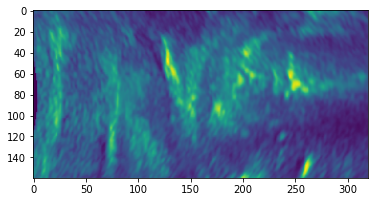

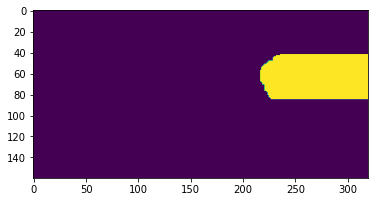

In [5]:
batchnum = 0
imgnum = 0
lbl = utils.first(test_loader[batchnum])["label"]
m = lbl[imgnum,0,:,:].max()
print(m)
if m == 1:
    img = utils.first(test_loader[0])["image"]
    plt.subplots()
    plt.imshow(img[imgnum,0,:,:])
    plt.subplots()
    plt.imshow(lbl[imgnum,0,:,:])
print("Data Size =", lbl.shape)

In [6]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:"+str(gpu_device))

In [7]:
def plot_vfold_training_curves(vfold_num, test_loader, min_size_comp, min_portion_comp, p_prior, graph):
    if graph:
        print("   VFOLD =", vfold_num, "of", num_folds)
    
    correct = 0
    incorrect = 0
    
    slice_correct = 0
    slice_incorrect = 0
    
    false_negatives = 0
    slice_false_negatives = 0
    
    loss_file = model_filename_base+"_loss_"+str(vfold_num)+".npy"
    if os.path.exists(loss_file):
        epoch_loss_values = np.load(loss_file)
    
        metric_file = model_filename_base+"_val_dice_"+str(vfold_num)+".npy"
        metric_values = np.load(metric_file)
    
        if graph:
            plt.figure("train", (12, 6))
            plt.subplot(1, 2, 1)
            plt.title("Epoch Average Loss")
            x = [i + 1 for i in range(len(epoch_loss_values))]
            y = epoch_loss_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.subplot(1, 2, 2)
            plt.title("Val Mean Dice")
            x = [2 * (i + 1) for i in range(len(metric_values))]
            y = metric_values
            plt.xlabel("epoch")
            plt.plot(x, y)
            plt.ylim([0.2,0.8])
            plt.show()
    
    model_file = model_filename_base+'.best_model.vfold_'+str(vfold_num)+'.pth'
    if os.path.exists(model_file):
        model = UNet(
            dimensions=net_in_dims,
            in_channels=net_in_channels,
            out_channels=num_classes,
            channels=net_channels,
            strides=net_strides,
            num_res_units=2,
            norm=Norm.BATCH,
        ).to(device)    
        model.load_state_dict(torch.load(model_file))
        model.eval()
        with torch.no_grad():
            i = 0
            fname = os.path.basename(test_files[vfold_num][i]["image"])
            prevfname = fname
            count1 = 0
            count = 0
            for b,test_data in enumerate(test_loader):
                test_outputs = sliding_window_inference(
                    test_data["image"].to(device), roi_size, batch_size_te, model
                )
                for j in range(test_outputs.shape[0]):
                    prevfname = fname
                    fname = os.path.basename(test_files[vfold_num][i]["image"])
                    
                    if fname[:22]!=prevfname[:22]:
                        #print("  ", prevfname[:22], "Count of slidings =", count1, "of", count)
                        if count1 == count:
                            if graph:
                                print("  Winner = Sliding")
                            if prevfname[3] == 's':
                                correct += 1
                            else:
                                incorrect += 1
                                false_negatives += 1
                                print(" FN Patient =", prevfname)
                        else:
                            if graph:
                                print("  Winner = Not Sliding")
                            if prevfname[3] == 'n':
                                correct += 1
                            else:
                                incorrect += 1
                                print(" FP Patient =", prevfname)
                        if graph:
                            print()
                            print()
                        count1 = 0
                        count = 0
                    
                    prob_shape = test_outputs[j,:,:,:].shape
                    prob = np.empty(prob_shape)
                    for c in range(num_classes):
                        itkProb = itk.GetImageFromArray(test_outputs[j,c,:,:].cpu())
                        imMathProb = ttk.ImageMath.New(itkProb)
                        imMathProb.Blur(5)
                        itkProb = imMathProb.GetOutput()
                        prob[c] = itk.GetArrayFromImage(itkProb)
                    arrc1 = np.zeros(prob[0].shape)
                    if False:
                        arrc1 = np.argmax(prob,axis=0)
                    else:
                        pmin = prob[0].min()
                        pmax = prob[0].max()
                        for c in range(1,num_classes):
                            pmin = min(pmin, prob[c].min())
                            pmax = min(pmax, prob[c].max())
                        prange = pmax - pmin
                        prob = (prob - pmin) / prange
                        for c in range(num_classes):
                            prob[c] = prob[c] * p_prior[c]
                        arrc1 = np.argmax(prob,axis=0)
                    
                    max_size = np.count_nonzero(test_data["label"][j, 0, :, :].cpu()>0)
                    min_thresh = max(min_size_comp, max_size*min_portion_comp)
                    
                    itkc1 = itk.GetImageFromArray(arrc1.astype(np.float32))
                    imMathC1 = ttk.ImageMath.New(itkc1)
                    for c in range(num_classes):
                        imMathC1.Erode(10,c,0)
                        imMathC1.Dilate(10,c,0)
                    itkc1 = imMathC1.GetOutputUChar()
                    arrc1 = itk.GetArrayFromImage(itkc1)
                    slice_count1 = np.count_nonzero(arrc1==1)
                    slice_count2 = np.count_nonzero(arrc1==2)
                    slice_decision = "Unknown"
                    slice_message = "Correct"
                    if slice_count2>slice_count1 and slice_count2>min_thresh:
                        count1 += 1
                        slice_decision = "Sliding"
                        if fname[3] == 's':
                            slice_correct += 1
                        else:
                            slice_incorrect += 1
                            slice_false_negatives += 1
                            slice_message = "False Negative"
                    else:
                        slice_decision = "Not Sliding"
                        if fname[3] == 'n':
                            slice_correct += 1
                        else:
                            slice_incorrect += 1
                            slice_message = "Fales Positive"
                    count += 1
                    

                    if graph:
                        print(fname)

                        plt.figure("check", (18, 6))
                        plt.subplot(1, 3, 1)
                        plt.title(f"image {i}")
                        tmpV = test_data["image"][j, 0, :, :]
                        plt.imshow(tmpV, cmap="gray")
                        plt.subplot(1, 3, 2)
                        plt.title(f"label {i}")
                        tmpV = test_data["label"][j, 0, :, :]
                        tmpV[0,0]=1
                        tmpV[0,1]=2
                        plt.imshow(tmpV)
                        plt.subplot(1, 3, 3)
                        plt.title(f"output {i}")
                        arrc1[0,0]=1
                        arrc1[0,1]=2
                        plt.imshow(arrc1[:,:])
                        plt.show()

                        print("Number of not-sliding / sliding pixel =", slice_count1, slice_count2)
                        print("    Min thresh =", min_thresh)
                        print("   ", slice_decision, "=", slice_message)
                        print()
                        print()

                        for c in range(num_classes):
                            arrimg = test_outputs.detach().cpu()[j,c,:,:]
                            itkimg = itk.GetImageFromArray(arrimg)
                            filename = model_filename_base+"_f"+str(vfold_num)+"_i"+str(i)+"_c"+str(c)+".nii.gz"
                            itk.imwrite(itkimg, filename)
                    
                    i += 1
                    
            #print("  ", prevfname[:22], "Count of slidings =", count1, "of", count)
            if count1 == count:
                if graph:
                    print("  Winner = Sliding")
                if prevfname[3] == 's':
                    correct += 1
                else:
                    incorrect += 1
                    false_negatives += 1
                    print(" FN Patient =", fname)
            else:
                if graph:
                    print("  Winner = Not Sliding")
                if prevfname[3] == 'n':
                    correct += 1
                else:
                    incorrect += 1
                    print(" FP Patient =", fname)
            if graph:
                print()
                print()
                
    return correct, incorrect, false_negatives, slice_correct, slice_incorrect, slice_false_negatives

*************
Prior = [1.1, 1.0, 0.95]
   VFOLD = 0 of 14


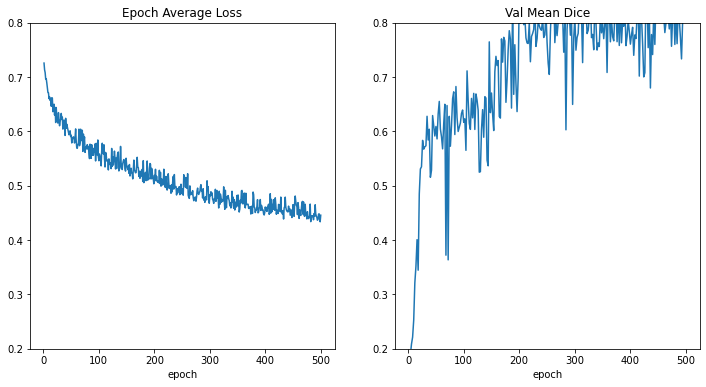

247ns_image_2734882394424_CLEAN.nii.gz


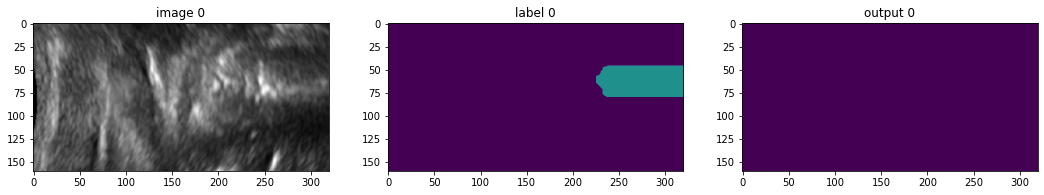

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


247ns_image_2743083265515_CLEAN.nii.gz


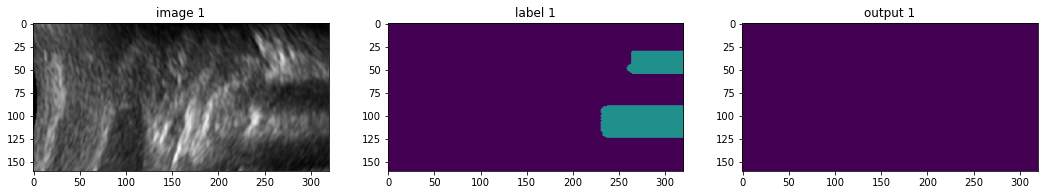

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


237s_iimage_24164968068436_CLEAN.nii.gz


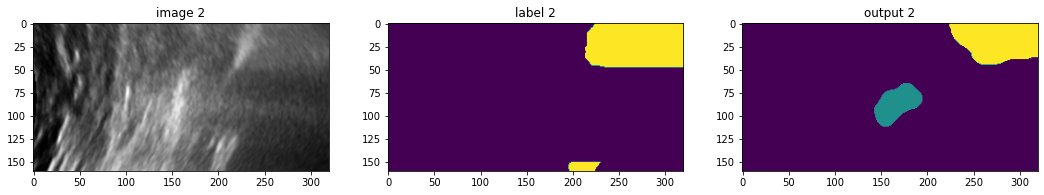

Number of not-sliding / sliding pixel = 1482 3479
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding
 FN Patient = 237s_iimage_24164968068436_CLEAN.nii.gz


   VFOLD = 1 of 14


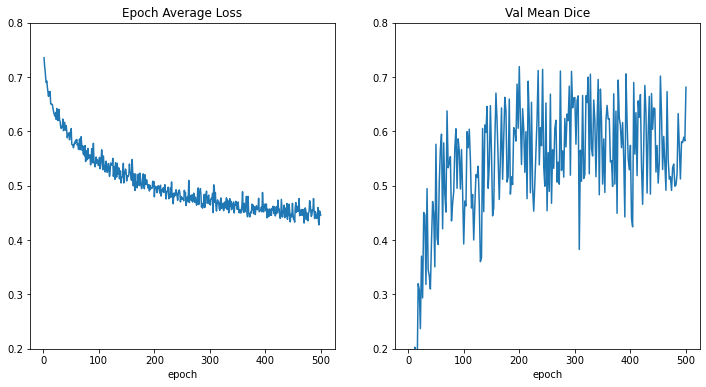

025ns_Image_262499828648_clean.nii.gz


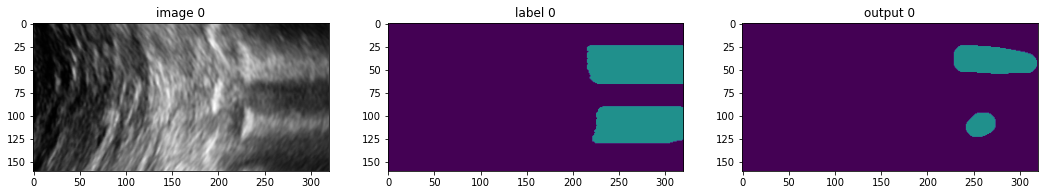

Number of not-sliding / sliding pixel = 2983 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


025ns_image_267456908021_clean.nii.gz


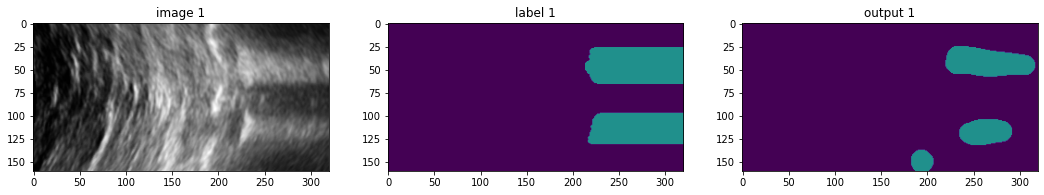

Number of not-sliding / sliding pixel = 4253 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


019s_iimage_10705997566592_CLEAN.nii.gz


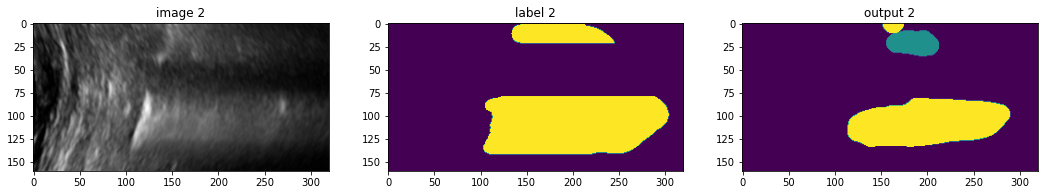

Number of not-sliding / sliding pixel = 1284 7402
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


019s_iimage_10891015221417_clean.nii.gz


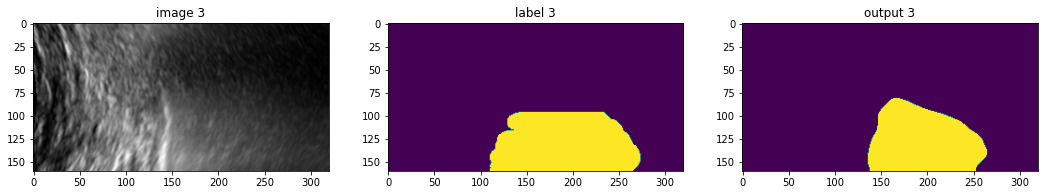

Number of not-sliding / sliding pixel = 0 7544
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 2 of 14


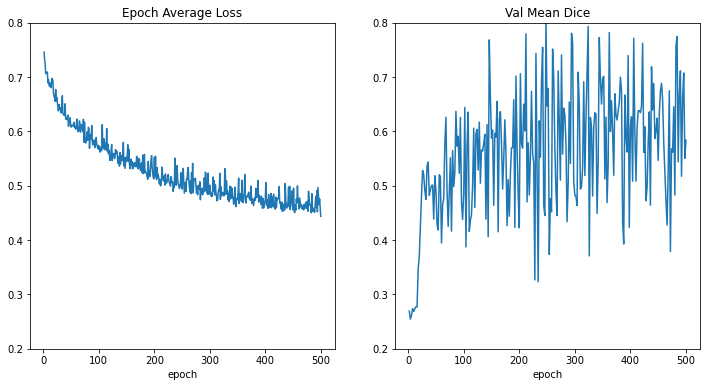

026ns_image_1083297968960_clean.nii.gz


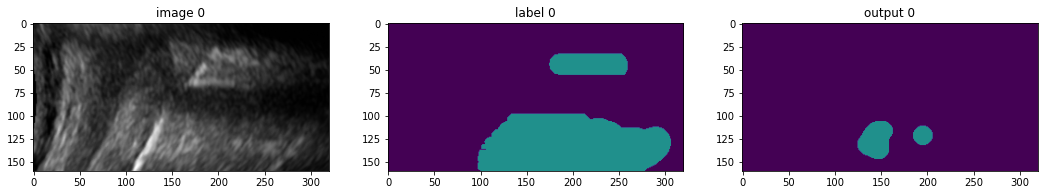

Number of not-sliding / sliding pixel = 1513 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


026ns_image_1087766719219_clean.nii.gz


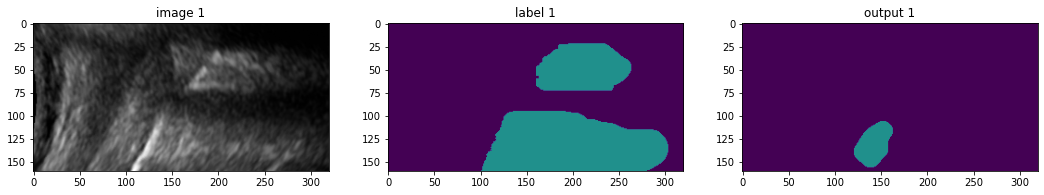

Number of not-sliding / sliding pixel = 1385 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


030s_iimage_1180496934444_clean.nii.gz


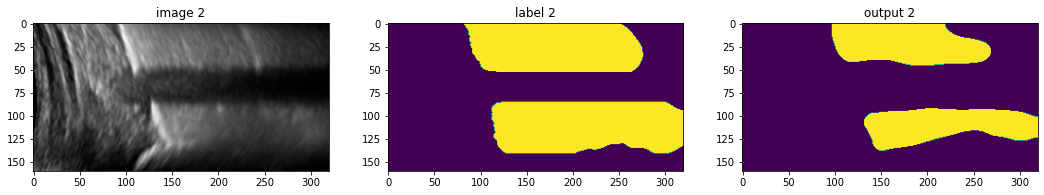

Number of not-sliding / sliding pixel = 0 12265
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


030s_iimage_677741729740_clean.nii.gz


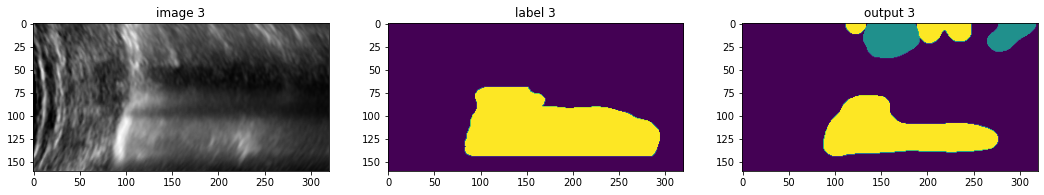

Number of not-sliding / sliding pixel = 3013 8555
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 3 of 14


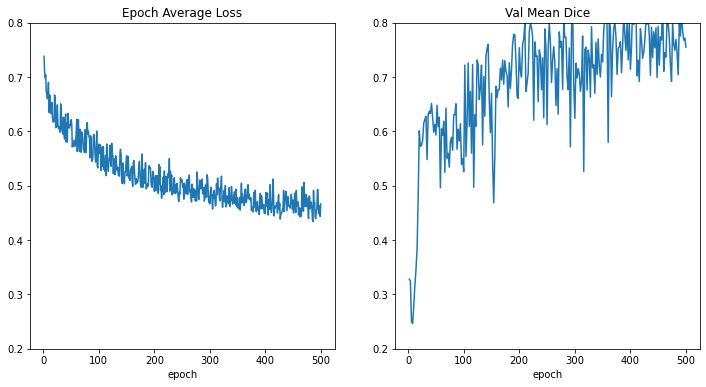

027ns_image_4641643404894_CLEAN.nii.gz


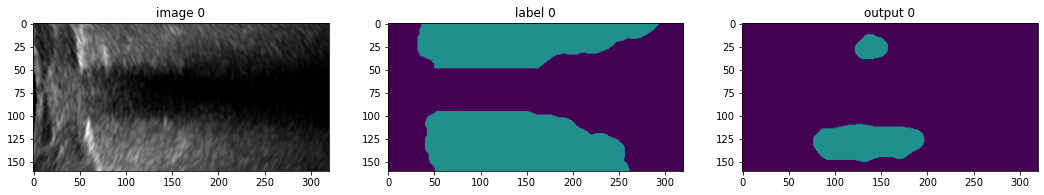

Number of not-sliding / sliding pixel = 4619 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


027ns_image_4743880599022_clean.nii.gz


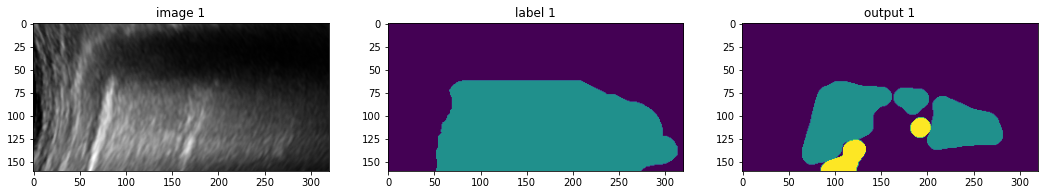

Number of not-sliding / sliding pixel = 9505 1332
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


034s_iimage_3368391807672_clean.nii.gz


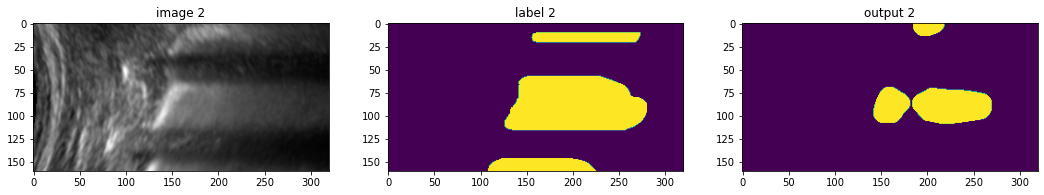

Number of not-sliding / sliding pixel = 0 4275
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


034s_iimage_3401832241774_clean.nii.gz


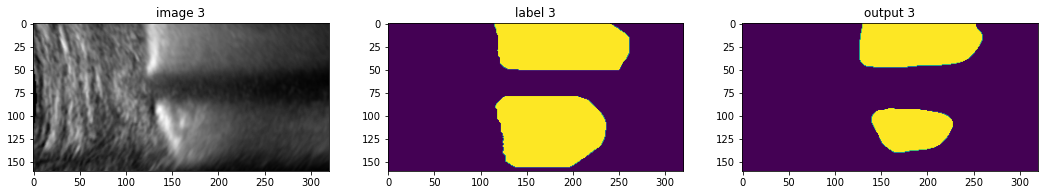

Number of not-sliding / sliding pixel = 0 9066
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 4 of 14


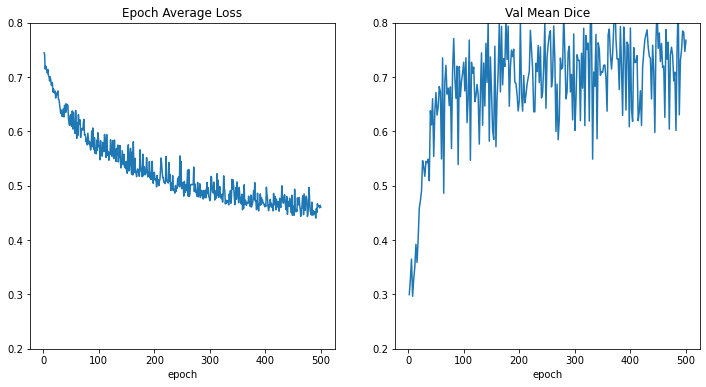

035ns_image_1394469579519_clean.nii.gz


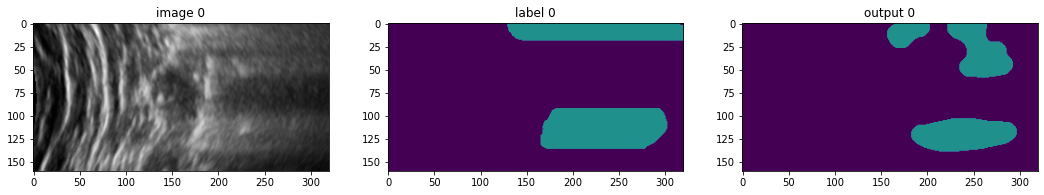

Number of not-sliding / sliding pixel = 6777 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


035ns_image_1404802450036_clean.nii.gz


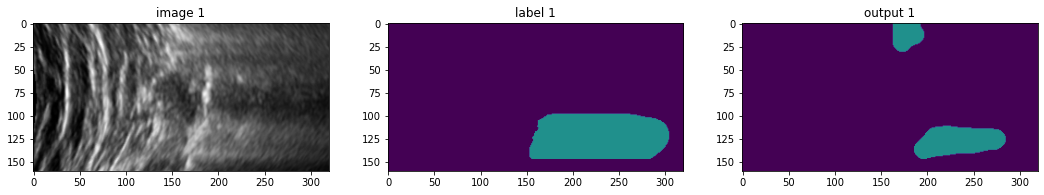

Number of not-sliding / sliding pixel = 3418 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


043s_iimage_10391571128899_CLEAN.nii.gz


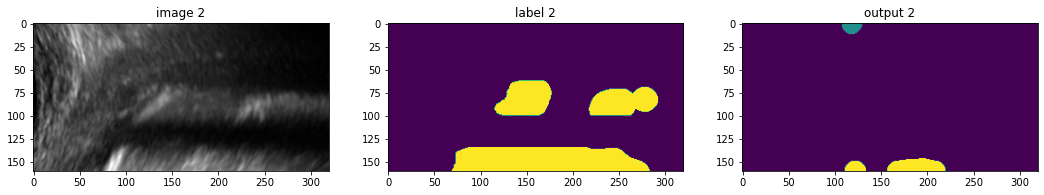

Number of not-sliding / sliding pixel = 211 926
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


043s_iimage_10395655826502_CLEAN.nii.gz


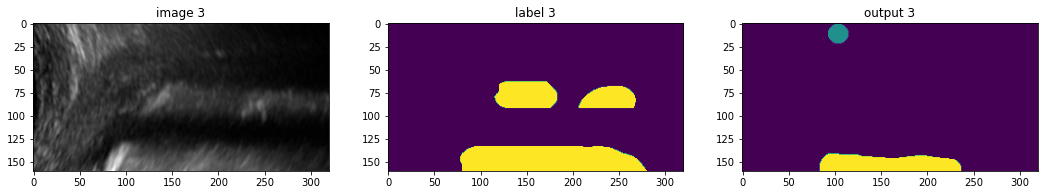

Number of not-sliding / sliding pixel = 370 2387
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 5 of 14


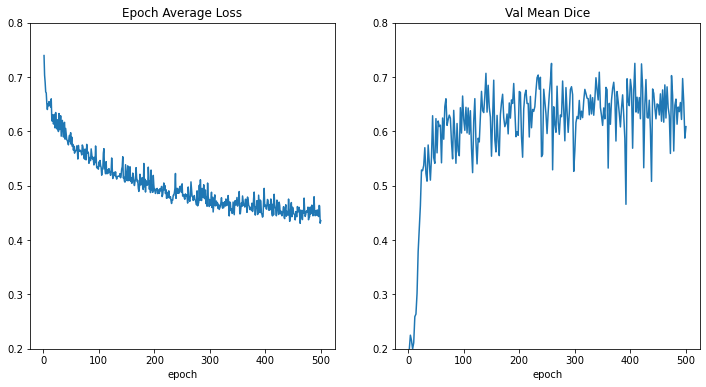

048ns_image_1543571117118_clean.nii.gz


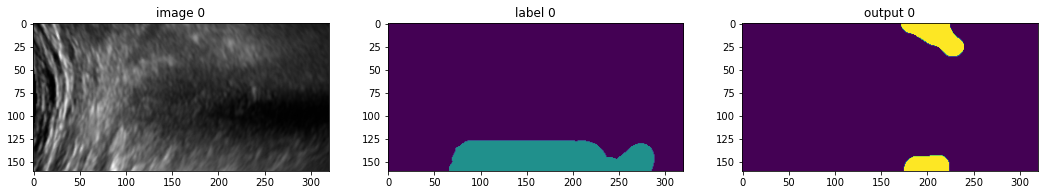

Number of not-sliding / sliding pixel = 0 2110
    Min thresh = 500
    Sliding = False Negative


  Winner = Sliding
 FN Patient = 048ns_image_1543571117118_clean.nii.gz


048ns_image_1749559540112_clean.nii.gz


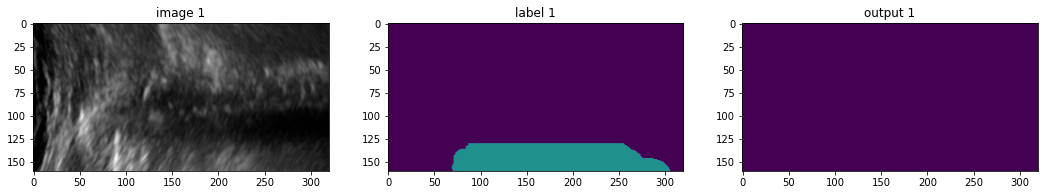

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


065s_iimage_1896534330004_clean.nii.gz


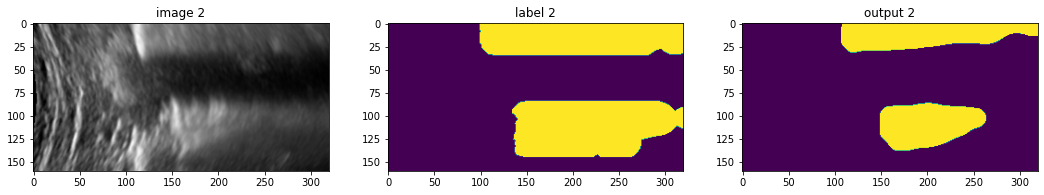

Number of not-sliding / sliding pixel = 0 9508
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


065s_iimage_1901852337971_clean.nii.gz


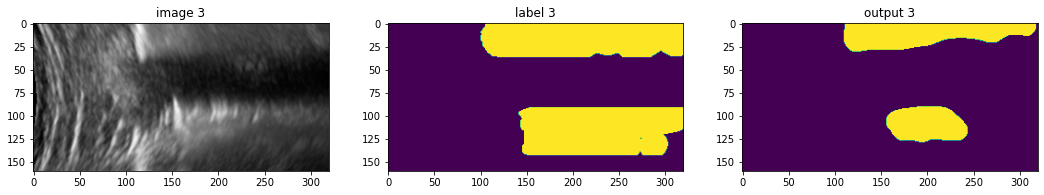

Number of not-sliding / sliding pixel = 0 7346
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 6 of 14


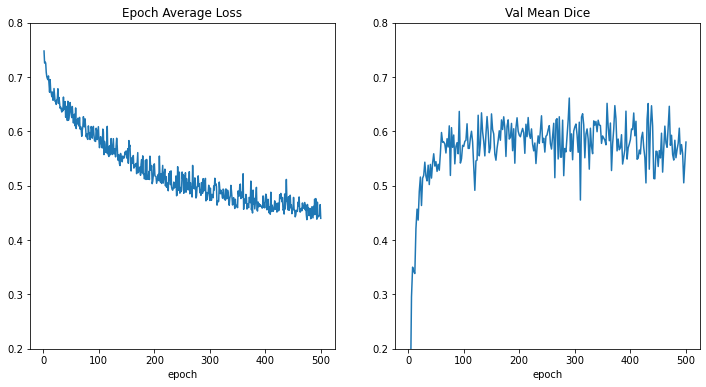

055ns_image_27180764486244_CLEAN.nii.gz


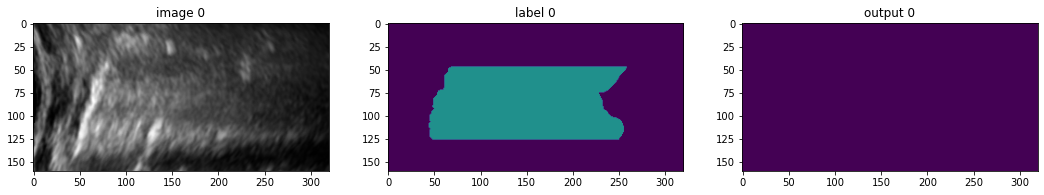

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


055ns_image_27185428518326_CLEAN.nii.gz


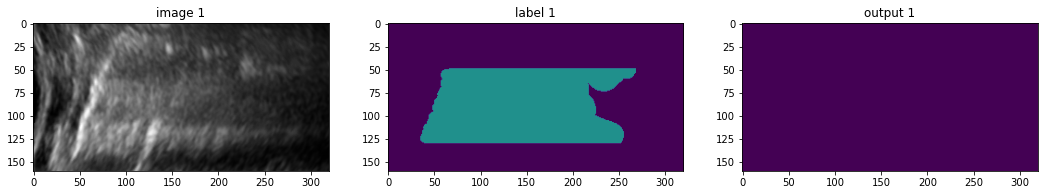

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


081s_iimage_2959672151786_clean.nii.gz


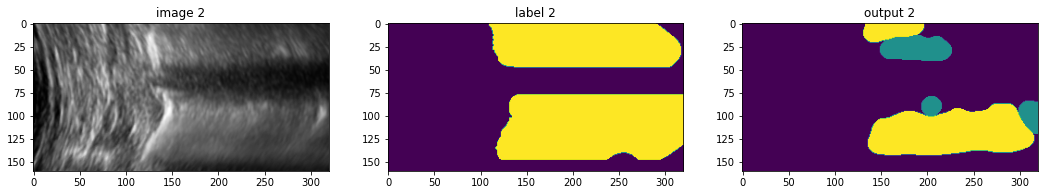

Number of not-sliding / sliding pixel = 2766 8716
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


081s_iimage_3320344386805_clean.nii.gz


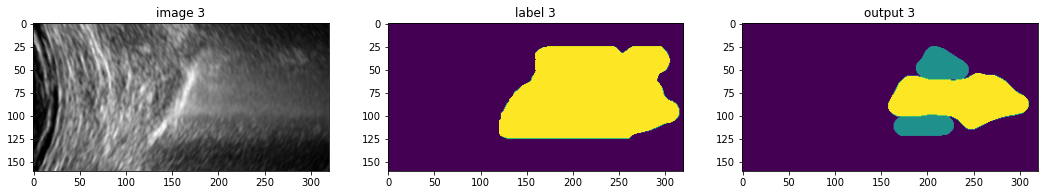

Number of not-sliding / sliding pixel = 2818 6130
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 7 of 14


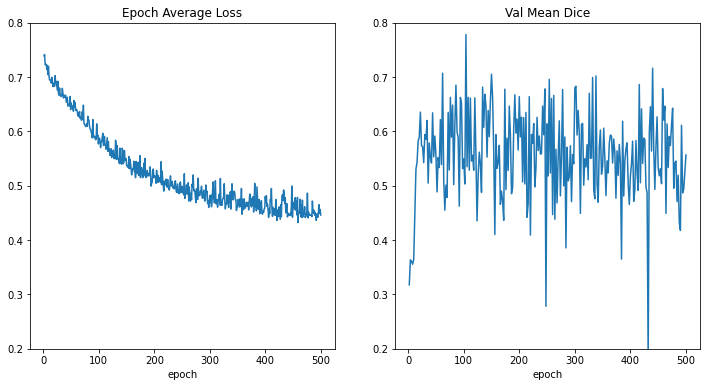

117ns_image_417221672548_CLEAN.nii.gz


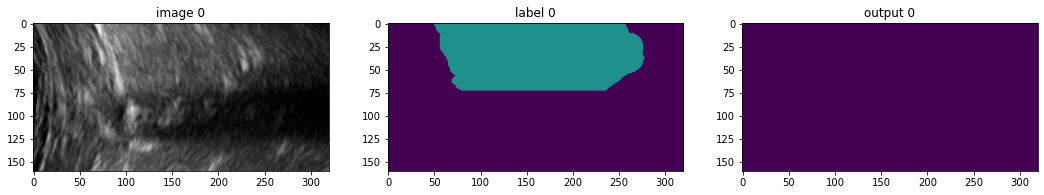

Number of not-sliding / sliding pixel = 0 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


117ns_image_426794579576_CLEAN.nii.gz


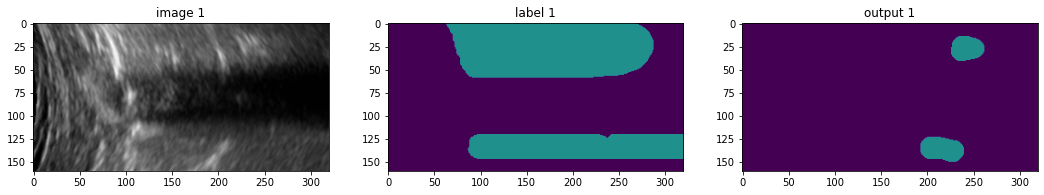

Number of not-sliding / sliding pixel = 1801 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


206s_iimage_1499268364374_clean.nii.gz


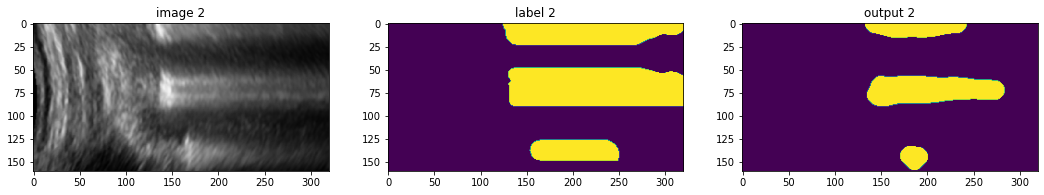

Number of not-sliding / sliding pixel = 0 5908
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


206s_iimage_1511338287338_clean.nii.gz


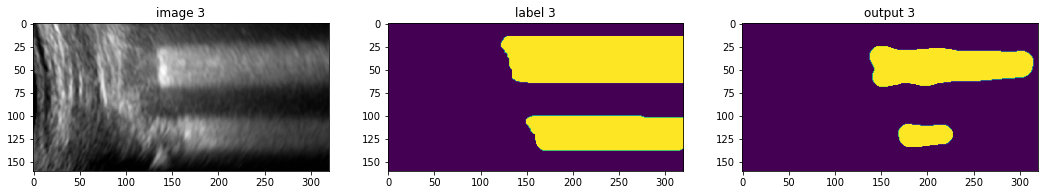

Number of not-sliding / sliding pixel = 0 7281
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 8 of 14


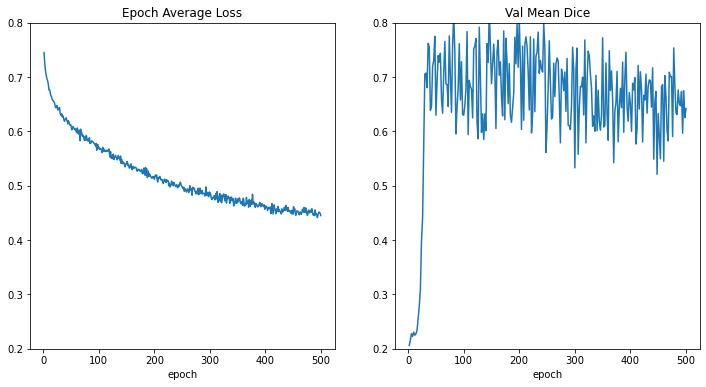

135ns_image_2418161753608_clean.nii.gz


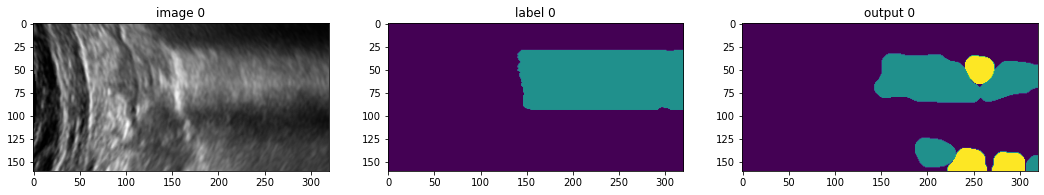

Number of not-sliding / sliding pixel = 8030 2255
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


135ns_image_2454526567135_CLEAN.nii.gz


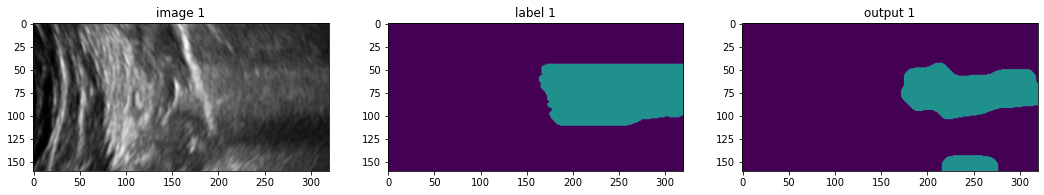

Number of not-sliding / sliding pixel = 7384 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


208s_iimage_104543812690743_CLEAN.nii.gz


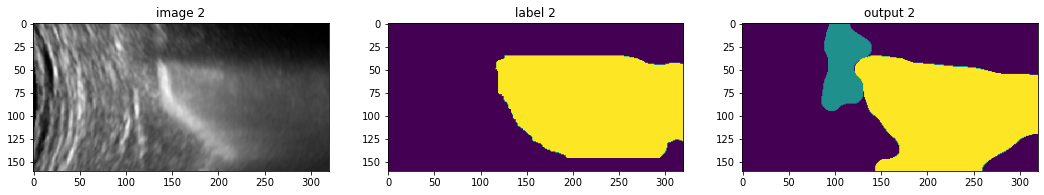

Number of not-sliding / sliding pixel = 3497 18485
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


208s_iimage_104548309385533_CLEAN.nii.gz


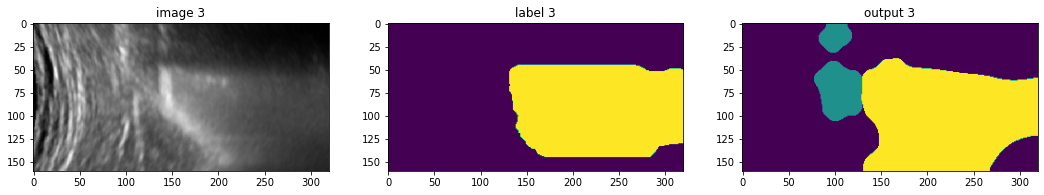

Number of not-sliding / sliding pixel = 3379 18356
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


208s_iimage_104932526155699_CLEAN.nii.gz


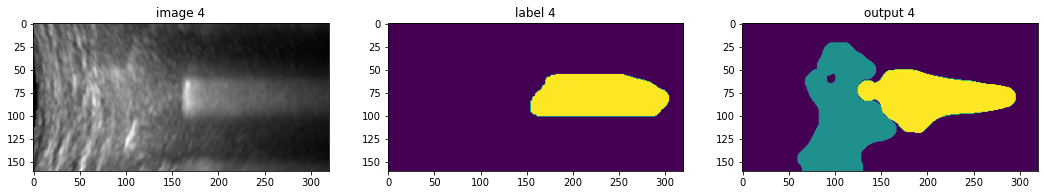

Number of not-sliding / sliding pixel = 8896 6801
    Min thresh = 500
    Not Sliding = Fales Positive


  Winner = Not Sliding
 FP Patient = 208s_iimage_104932526155699_CLEAN.nii.gz


   VFOLD = 9 of 14


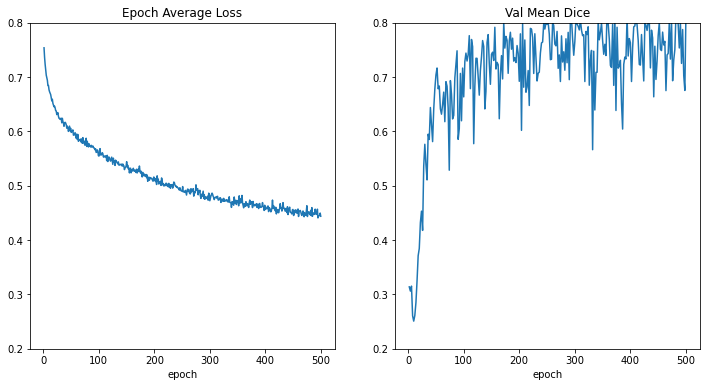

193ns_image_634125159704_CLEAN.nii.gz


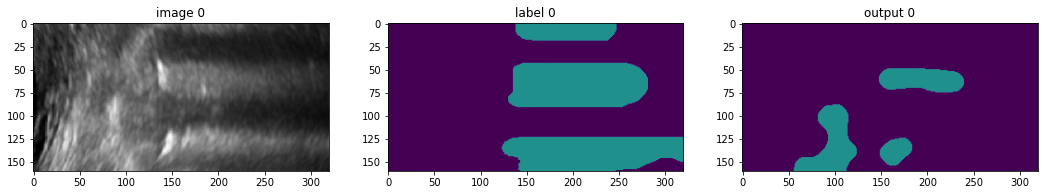

Number of not-sliding / sliding pixel = 5213 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


193ns_image_642169070951_clean.nii.gz


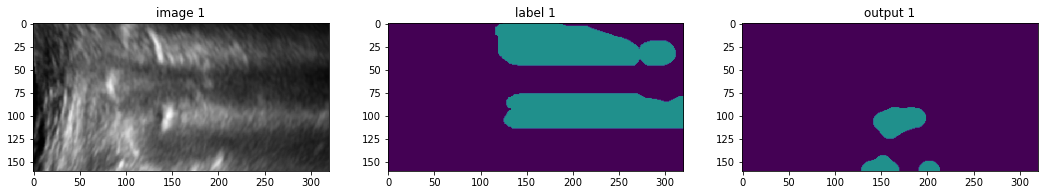

Number of not-sliding / sliding pixel = 2074 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


211s_iimage_3925135436261_clean.nii.gz


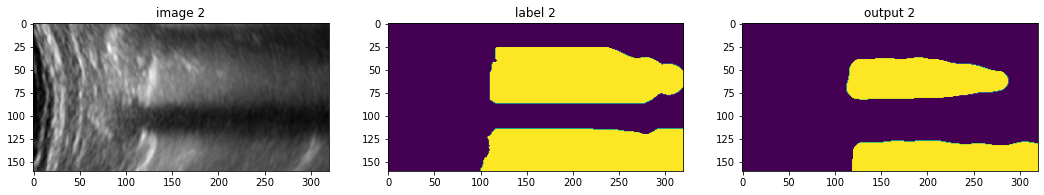

Number of not-sliding / sliding pixel = 0 12610
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


211s_iimage_3929217595322_clean.nii.gz


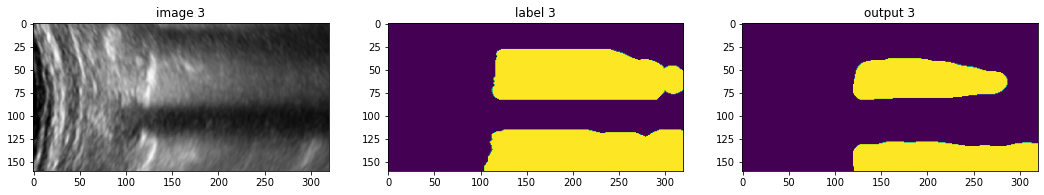

Number of not-sliding / sliding pixel = 0 11922
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 10 of 14


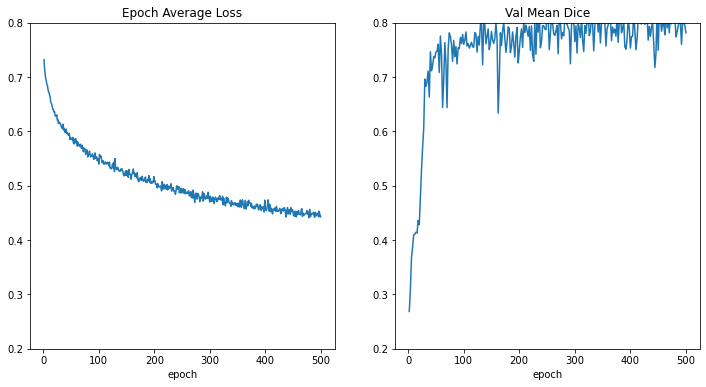

210ns_image_603665940081_clean.nii.gz


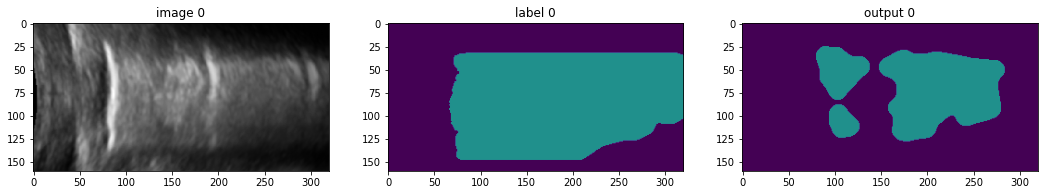

Number of not-sliding / sliding pixel = 12638 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


210ns_image_614587120545_clean.nii.gz


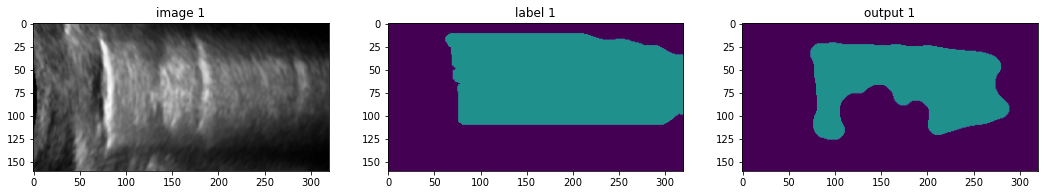

Number of not-sliding / sliding pixel = 14717 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


212s_iimage_128683942015128_CLEAN.nii.gz


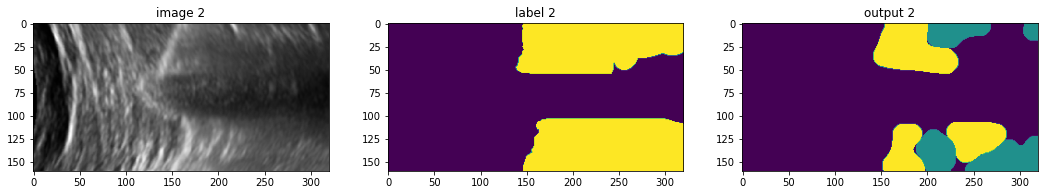

Number of not-sliding / sliding pixel = 5172 7266
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


212s_iimage_128688523296793_CLEAN.nii.gz


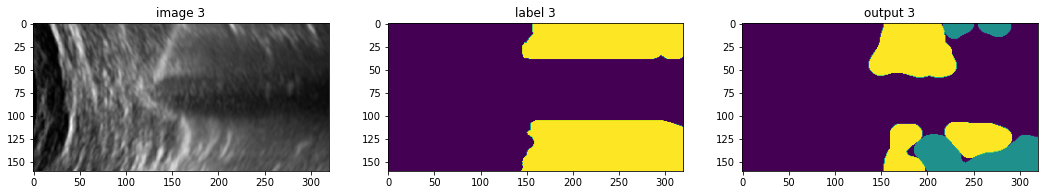

Number of not-sliding / sliding pixel = 4515 8288
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


212s_iimage_128692595484031_CLEAN.nii.gz


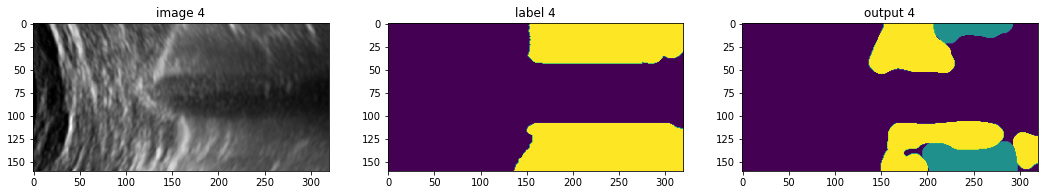

Number of not-sliding / sliding pixel = 3936 9107
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 11 of 14


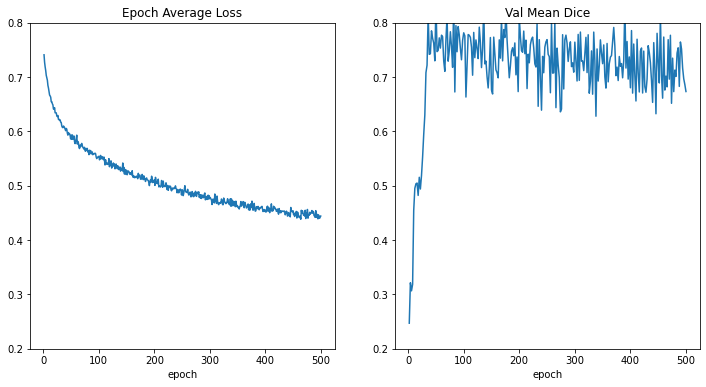

218ns_image_6056976176281_CLEAN.nii.gz


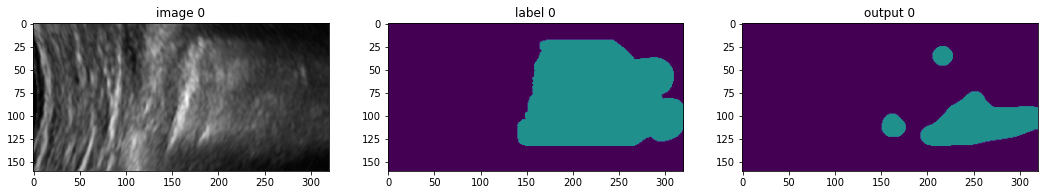

Number of not-sliding / sliding pixel = 5549 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


218ns_image_6370410622099_CLEAN.nii.gz


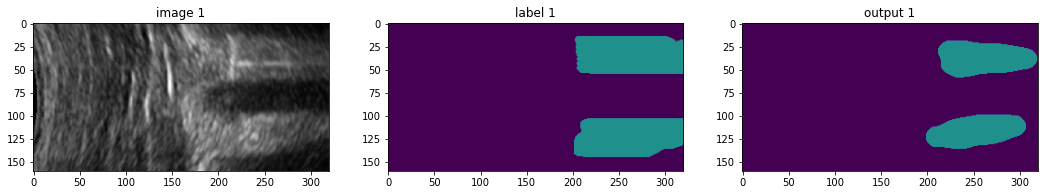

Number of not-sliding / sliding pixel = 6266 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


224s_iimage_3308406916756_clean.nii.gz


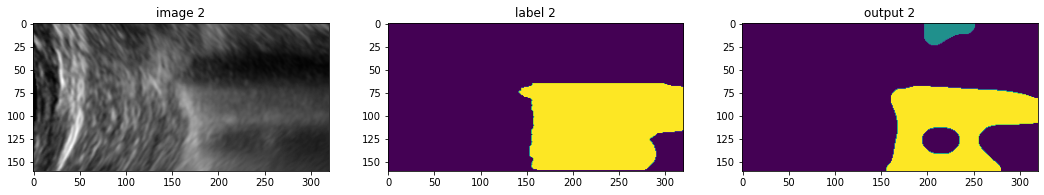

Number of not-sliding / sliding pixel = 912 10057
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


224s_iimage_3315947589826_clean.nii.gz


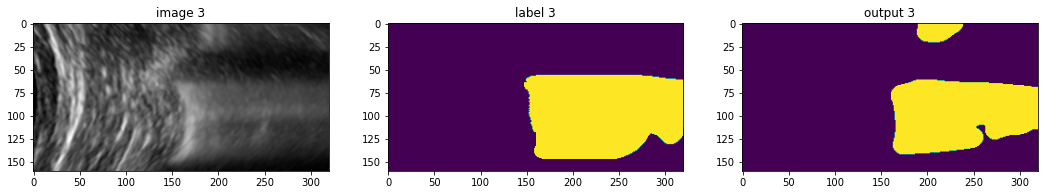

Number of not-sliding / sliding pixel = 0 11302
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 12 of 14


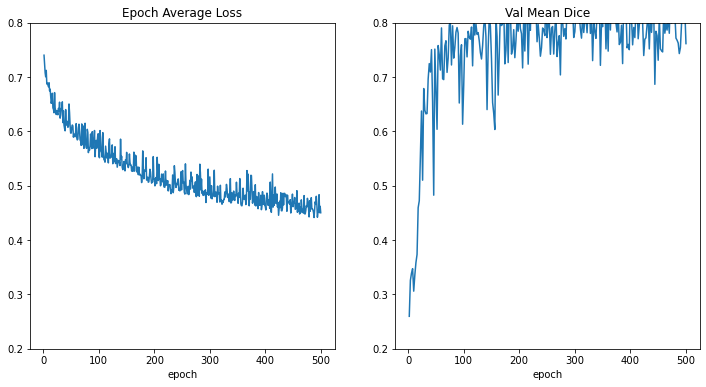

219ns_image_1884162273498_clean.nii.gz


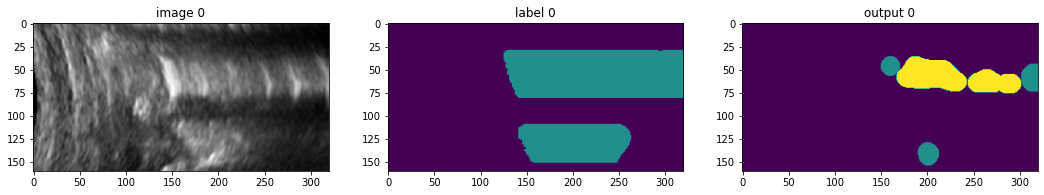

Number of not-sliding / sliding pixel = 1271 3264
    Min thresh = 500
    Sliding = False Negative


  Winner = Sliding
 FN Patient = 219ns_image_1884162273498_clean.nii.gz


219ns_image_1895283541879_clean.nii.gz


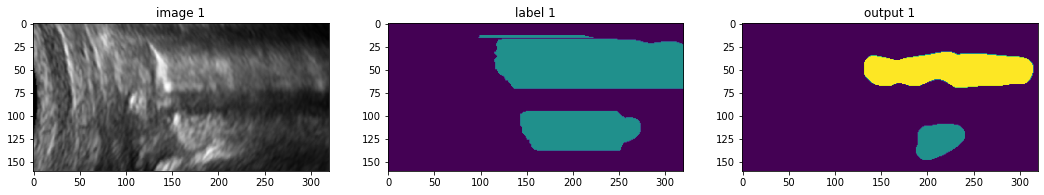

Number of not-sliding / sliding pixel = 1566 5661
    Min thresh = 500
    Sliding = False Negative


  Winner = Sliding
 FN Patient = 219ns_image_1895283541879_clean.nii.gz


228s_iimage_3321463845606_clean.nii.gz


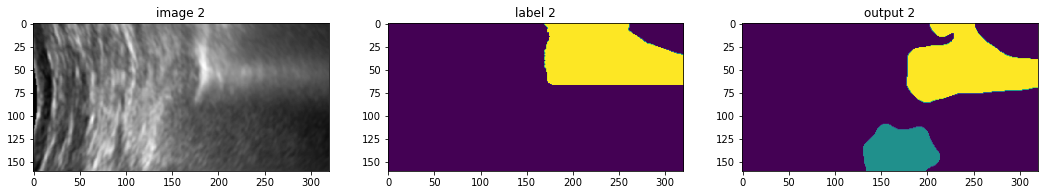

Number of not-sliding / sliding pixel = 3379 7857
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


228s_iimage_3384882513134_clean.nii.gz


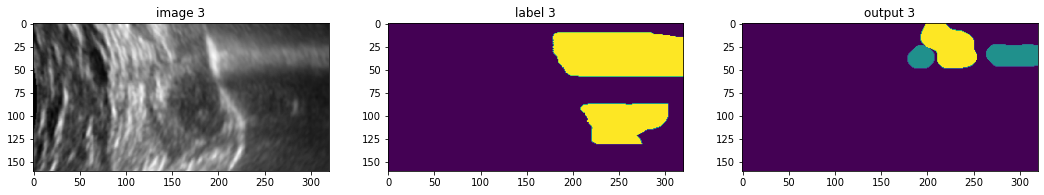

Number of not-sliding / sliding pixel = 1819 2109
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


   VFOLD = 13 of 14


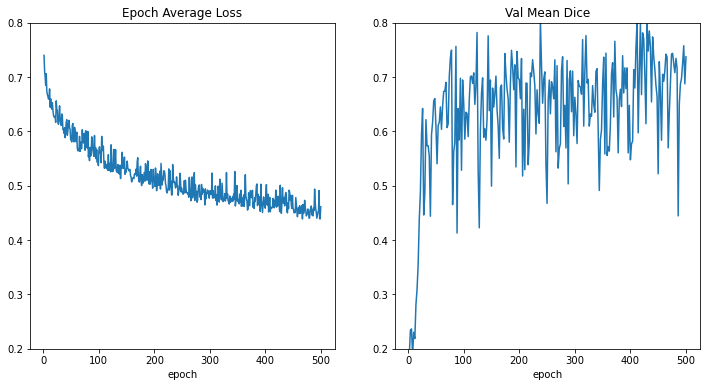

221ns_image_584357289931_clean.nii.gz


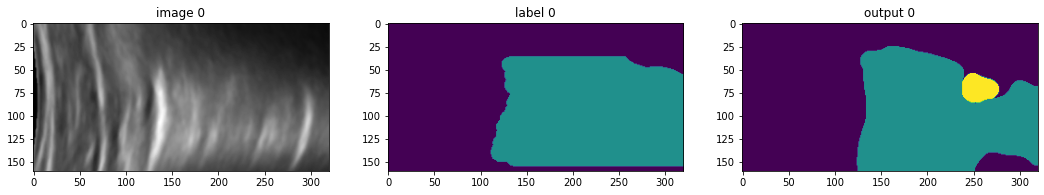

Number of not-sliding / sliding pixel = 19802 977
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


221ns_image_588695055398_clean.nii.gz


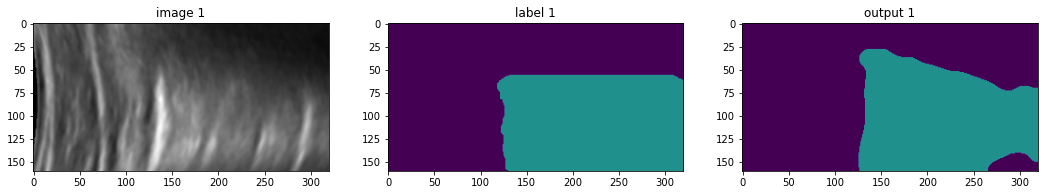

Number of not-sliding / sliding pixel = 19943 0
    Min thresh = 500
    Not Sliding = Correct


  Winner = Not Sliding


236s_iimage_1139765223418_CLEAN.nii.gz


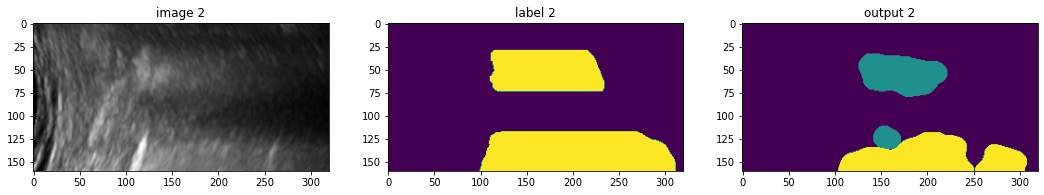

Number of not-sliding / sliding pixel = 3954 5546
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding


236s_iimage_1327616672148_clean.nii.gz


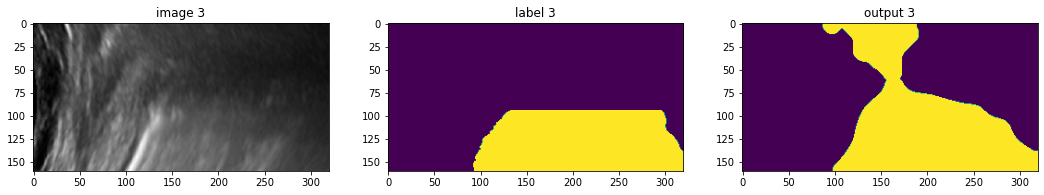

Number of not-sliding / sliding pixel = 0 17737
    Min thresh = 500
    Sliding = Correct


  Winner = Sliding




Patients: Correct = 52 Incorrect = 5 Not Sliding as Sliding = 4
Slices: Correct = 53 Incorrect =  4 Not Sliding as Sliding = 3
*************


In [10]:
min_size = 500
min_portion = 0.0

for prior in [[1.1,1.0,0.95]]: #[0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6]:
    print('*************')
    print("Prior =", prior)
    correct = 0
    incorrect = 0
    false_negatives = 0
    slice_correct = 0
    slice_incorrect = 0
    slice_false_negatives = 0
    for i in range(num_folds):
        (fcorrect, fincorrect, ffalse_negatives, fslice_correct, fslice_incorrect, fslice_false_negatives) = plot_vfold_training_curves(i, test_loader[i],
            min_size, min_portion, prior, True)
        correct += fcorrect
        incorrect += fincorrect
        false_negatives += ffalse_negatives
        slice_correct += fslice_correct
        slice_incorrect += fslice_incorrect
        slice_false_negatives += fslice_false_negatives
    print()
    print()
    print("Patients: Correct =", correct, "Incorrect =", incorrect, "Not Sliding as Sliding =", false_negatives)
    print("Slices: Correct =", slice_correct, "Incorrect = ", slice_incorrect, "Not Sliding as Sliding =", slice_false_negatives)
    print('*************')
